In [ ]:
pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.3 MB/s 


# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from skimage import io
import cv2
from sklearn.model_selection import train_test_split, KFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.utils import shuffle
from scipy.io import loadmat

import tensorflow
from tensorflow import keras
from tensorflow import cast
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import vgg16
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
import gc

In [ ]:
import os

# Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
# !unzip "/content/drive/MyDrive/dataset_cv/labels.zip" -d "/content/drive/MyDrive/dataset_cv"

In [ ]:
# !unzip "/content/drive/MyDrive/dataset_cv/imgs.zip" -d "/content/drive/MyDrive/dataset_cv"

# Loading labels dataset

In [ ]:
labelsPath = "/content/drive/MyDrive/dataset_cv/labels/"
imagesPath = "/content/drive/MyDrive/dataset_cv/imgs/"

In [ ]:
categories = pd.read_csv(os.path.join(labelsPath,"categories.csv"),names=["Names"])

In [ ]:
vector = categories["Names"].tolist()
labels_head = ["image"]+vector

In [ ]:
labels_train = pd.read_csv(os.path.join(labelsPath,"labels_train.csv"),names=labels_head)

In [ ]:
categories.head()

,Names
0,person
1,bicycle
2,car
3,motorcycle
4,airplane


In [ ]:
labels_train.head()

,image,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,traffic light,fire hydrant,stop sign,parking meter,bench,bird,cat,dog,horse,sheep,cow,elephant,bear,zebra,giraffe,backpack,umbrella,handbag,tie,suitcase,frisbee,skis,snowboard,sports ball,kite,baseball bat,baseball glove,skateboard,surfboard,tennis racket,...,wine glass,cup,fork,knife,spoon,bowl,banana,apple,sandwich,orange,broccoli,carrot,hot dog,pizza,donut,cake,chair,couch,potted plant,bed,dining table,toilet,tv,laptop,mouse,remote,keyboard,cell phone,microwave,oven,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,000000000001.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000000000002.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000000000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000000000005.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000000000006.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
categories.count()

Names    80
dtype: int64

In [ ]:
labels_train["person"].value_counts()[1.0]

53529

In [ ]:
counts_per_class = {}
for name in vector:
  counts_per_class[name] = labels_train[name].value_counts()[1.0]

# Plotting Dataset

In [ ]:
def plotDataset(counts_per_class):
  labels = list(counts_per_class.keys())
  counts = list(counts_per_class.values())
    
  fig = plt.figure(figsize = (20, 5))
  
  plt.bar(labels, counts, width = 0.5)
  plt.xticks(range(len(labels)), labels, rotation='vertical')
  plt.xlabel("Classes")
  plt.ylabel("No. of images having the class")
  plt.title("Counts per class graph")
  plt.show()


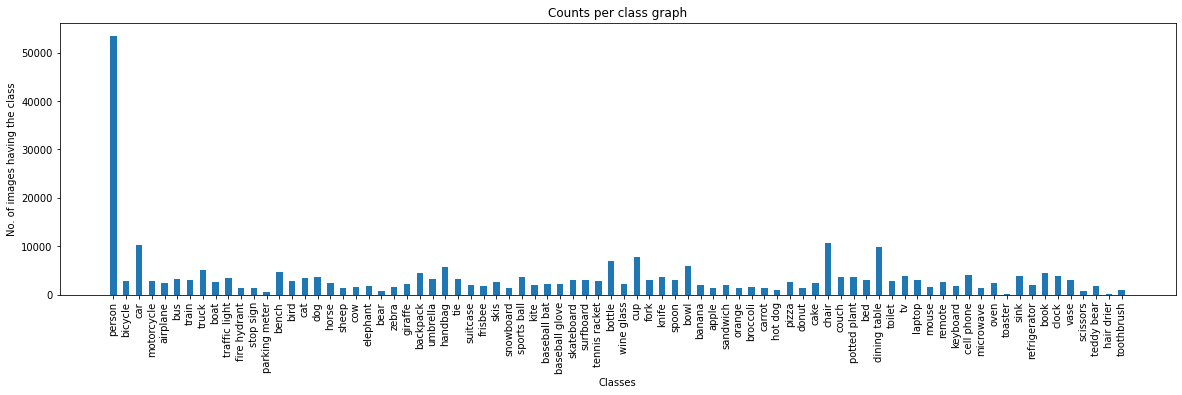

In [ ]:
plotDataset(counts_per_class)

In [ ]:
# labels_train.iloc['000000000001.jpg']
x = labels_train.loc[labels_train['image']=="000000000001.jpg"]
x.values[:,1:][0]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0], dtype=object)

# Loading images dataset

In [ ]:
def load_dataset(folder, n=None):
    images = []
    labels = []
    it = 0
    dir_list = os.listdir(folder)
    for filename in dir_list:
        # print(filename)
        it += 1
        # print(os.path.join(folder,filename))
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        images.append(img)

        label = labels_train.loc[labels_train['image']==filename].values[:,1:]
        # print(label)
        labels.append(label[0])

        if(it%1000==0):
          print(it,"images done")
        if(it >= n):
          break

        
    return images, labels

In [ ]:
x_train, y_train = load_dataset(imagesPath+"train",n=5000)

1000 images done
2000 images done
3000 images done
4000 images done
5000 images done


In [ ]:
with open('/content/drive/MyDrive/dataset_cv/images.npy', 'wb') as f:
    np.save(f, np.array(x_train))

with open('/content/drive/MyDrive/dataset_cv/labels.npy', 'wb') as f:
    np.save(f, np.array(y_train))

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.8 MB/s 


In [ ]:
x_train = np.array(x_train,dtype=np.float32)
y_train = np.array(y_train,dtype=np.float32)

# Splitting dataset

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
x_train, y_train, x_test, y_test = iterative_train_test_split(x_train,y_train,test_size=.2)

In [ ]:
len(x_train)

4004

In [ ]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# counts_per_class_train = {}
# for i in len(y_train):

counts_train=np.sum(y_train,axis=0)
counts_test=np.sum(y_test,axis=0)

# counts_per_class = {}
# for name in vector:
#   counts_per_class[name] = labels_train[name].value_counts()[1.0]

In [ ]:
counts_train

array([2203.,  109.,  424.,  131.,  121.,  138.,  119.,  218.,   96.,
        145.,   62.,   49.,   27.,  182.,  112.,  145.,  147.,   96.,
         40.,   78.,   70.,   31.,   67.,   86.,  170.,  151.,  227.,
        145.,   70.,   64.,  103.,   52.,  145.,   76.,   88.,   98.,
        120.,  120.,  122.,  270.,   67.,  291.,  110.,  128.,   94.,
        221.,   74.,   43.,   68.,   64.,   70.,   67.,   39.,  114.,
         58.,   94.,  435.,  143.,  161.,  131.,  374.,  109.,  141.,
        119.,   58.,  105.,   86.,  154.,   43.,   81.,    7.,  151.,
         67.,  189.,  172.,  127.,   46.,   64.,    9.,   33.],
      dtype=float32)

In [ ]:
counts_test

array([551.,  31., 108.,  33.,  30.,  35.,  30.,  55.,  24.,  36.,  16.,
        12.,   7.,  45.,  28.,  36.,  37.,  24.,  10.,  19.,  17.,   8.,
        17.,  22.,  44.,  37.,  59.,  36.,  20.,  16.,  26.,  13.,  39.,
        19.,  22.,  25.,  30.,  30.,  30.,  76.,  21.,  76.,  29.,  39.,
        29.,  61.,  19.,  11.,  17.,  16.,  18.,  17.,  11.,  29.,  14.,
        24., 113.,  41.,  42.,  38.,  99.,  27.,  38.,  32.,  16.,  26.,
        22.,  39.,  14.,  22.,   2.,  40.,  18.,  51.,  43.,  32.,  11.,
        16.,   2.,   9.], dtype=float32)

In [ ]:
counts_train/counts_test

array([3.9981852, 3.516129 , 3.925926 , 3.969697 , 4.0333333, 3.942857 ,
       3.9666667, 3.9636364, 4.       , 4.0277777, 3.875    , 4.0833335,
       3.857143 , 4.0444446, 4.       , 4.0277777, 3.9729729, 4.       ,
       4.       , 4.105263 , 4.117647 , 3.875    , 3.9411764, 3.909091 ,
       3.8636363, 4.081081 , 3.8474576, 4.0277777, 3.5      , 4.       ,
       3.9615386, 4.       , 3.7179487, 4.       , 4.       , 3.92     ,
       4.       , 4.       , 4.0666666, 3.5526316, 3.1904762, 3.8289473,
       3.7931035, 3.2820513, 3.2413793, 3.6229508, 3.8947368, 3.909091 ,
       4.       , 4.       , 3.8888888, 3.9411764, 3.5454545, 3.9310346,
       4.142857 , 3.9166667, 3.8495576, 3.487805 , 3.8333333, 3.4473684,
       3.7777777, 4.037037 , 3.7105262, 3.71875  , 3.625    , 4.0384617,
       3.909091 , 3.9487178, 3.0714285, 3.6818182, 3.5      , 3.775    ,
       3.7222223, 3.7058823, 4.       , 3.96875  , 4.181818 , 4.       ,
       4.5      , 3.6666667], dtype=float32)

In [ ]:
gc.collect()

425

## Storing X_train, Y_train, X_test, Y_test in different files

In [ ]:
x_train = np.load('/content/drive/MyDrive/CV/images.npy')
y_train = np.load('/content/drive/MyDrive/CV/labels.npy', allow_pickle=True)

In [ ]:
label_name = pd.read_csv('/content/drive/MyDrive/CV/categories.csv', names=['classes'])
label_name = label_name.values[:, 0]

In [ ]:
freq = np.sum(y_train, axis=0)

In [ ]:
np.sum(y_train, axis=0), freq

(array([2754.0, 140.0, 532.0, 164.0, 151.0, 173.0, 149.0, 273.0, 120.0,
        181.0, 78.0, 61.0, 34.0, 227.0, 140.0, 181.0, 184.0, 120.0, 50.0,
        97.0, 87.0, 39.0, 84.0, 108.0, 214.0, 188.0, 286.0, 181.0, 90.0,
        80.0, 129.0, 65.0, 184.0, 95.0, 110.0, 123.0, 150.0, 150.0, 152.0,
        346.0, 88.0, 367.0, 139.0, 167.0, 123.0, 282.0, 93.0, 54.0, 85.0,
        80.0, 88.0, 84.0, 50.0, 143.0, 72.0, 118.0, 548.0, 184.0, 203.0,
        169.0, 473.0, 136.0, 179.0, 151.0, 74.0, 131.0, 108.0, 193.0, 57.0,
        103.0, 9.0, 191.0, 85.0, 240.0, 215.0, 159.0, 57.0, 80.0, 11.0,
        42.0], dtype=object),
 array([2754.0, 140.0, 532.0, 164.0, 151.0, 173.0, 149.0, 273.0, 120.0,
        181.0, 78.0, 61.0, 34.0, 227.0, 140.0, 181.0, 184.0, 120.0, 50.0,
        97.0, 87.0, 39.0, 84.0, 108.0, 214.0, 188.0, 286.0, 181.0, 90.0,
        80.0, 129.0, 65.0, 184.0, 95.0, 110.0, 123.0, 150.0, 150.0, 152.0,
        346.0, 88.0, 367.0, 139.0, 167.0, 123.0, 282.0, 93.0, 54.0, 85.0,
        80.0,

In [ ]:
y_train.shape, freq.shape

((5000, 80), (80,))

In [ ]:
y_new = []
label_name_new = []
threshold = 100
for i in range(80):
    if freq[i] >= threshold:
        y_new.append(y_train[:, i])
        label_name_new.append(label_name[i])

In [ ]:
y_train = np.array(y_new, np.float32)
x_train = np.array(x_train, np.float32)
label_name = np.array(label_name_new)

y_train = np.transpose(y_train)
y_train.shape, label_name.shape, x_train.shape

((5000, 51), (51,), (5000, 256, 256, 3))

In [ ]:
freq_ = np.sum(y_new, axis=1)

In [ ]:
label_name

array(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
       'train', 'truck', 'boat', 'traffic light', 'bench', 'bird', 'cat',
       'dog', 'horse', 'giraffe', 'backpack', 'umbrella', 'handbag',
       'tie', 'skis', 'sports ball', 'baseball bat', 'baseball glove',
       'skateboard', 'surfboard', 'tennis racket', 'bottle', 'cup',
       'fork', 'knife', 'spoon', 'bowl', 'pizza', 'cake', 'chair',
       'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
       'laptop', 'remote', 'keyboard', 'cell phone', 'oven', 'sink',
       'book', 'clock', 'vase'], dtype='<U14')

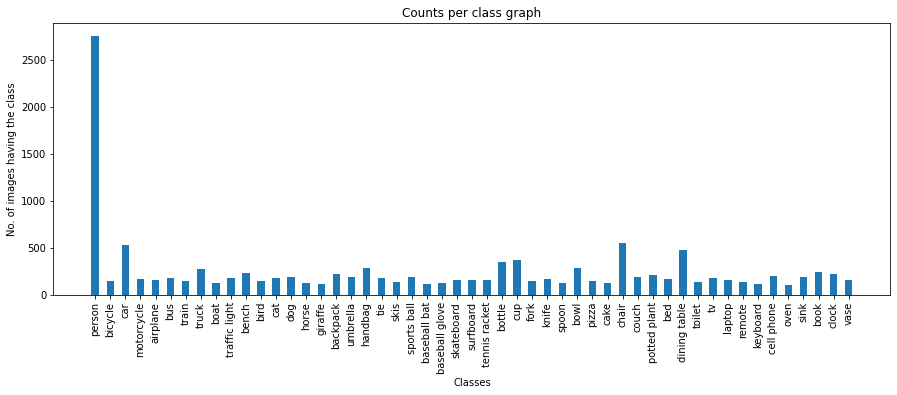

In [ ]:
fig = plt.figure(figsize = (15, 5))
  
plt.bar(label_name,freq_, width = 0.5)
plt.xticks(range(len(label_name)), label_name, rotation='vertical')
plt.xlabel("Classes")
plt.ylabel("No. of images having the class")
plt.title("Counts per class graph")
plt.show()

In [ ]:
np.array(y_new)

array([[1.0, 1.0, 0.0, ..., 1.0, 1.0, 1.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [ ]:
np.sum(y_train, axis=0)

array([2754.,  140.,  532.,  164.,  151.,  173.,  149.,  273.,  120.,
        181.,  227.,  140.,  181.,  184.,  120.,  108.,  214.,  188.,
        286.,  181.,  129.,  184.,  110.,  123.,  150.,  150.,  152.,
        346.,  367.,  139.,  167.,  123.,  282.,  143.,  118.,  548.,
        184.,  203.,  169.,  473.,  136.,  179.,  151.,  131.,  108.,
        193.,  103.,  191.,  240.,  215.,  159.], dtype=float32)

In [ ]:
x_train, y_train, x_test, y_test = iterative_train_test_split(x_train,y_train,test_size=.1)

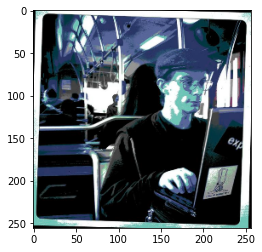

In [ ]:
plt.imshow(x_train[0].astype(np.uint8))

In [ ]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
# label_name 
for i in range(len(y_train[0])):
  if (y_train[0][i]==1.0):
    print(label_name[i])

person
chair
laptop


# Testing the final dataset 

In [ ]:
# train images
def testings(index):
  plt.imshow(x_train[index].astype(np.uint8))
  for i in range(len(y_train[index])):
    if (y_train[index][i]==1.0):
      print(label_name[i])


In [ ]:
# test images
def testings_2(index):
  plt.imshow(x_test[index].astype(np.uint8))
  for i in range(len(y_test[index])):
    if (y_test[index][i]==1.0):
      print(label_name[i])


person
umbrella
chair


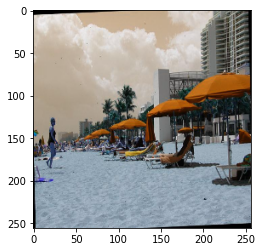

In [ ]:
testings_2(0)

person
dog
backpack
skis


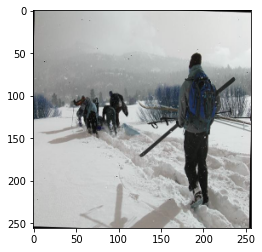

In [ ]:
testings_2(1)

person
umbrella
chair


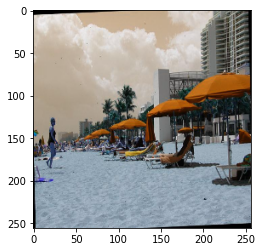

In [ ]:
testings(0)

bench
bottle
bowl


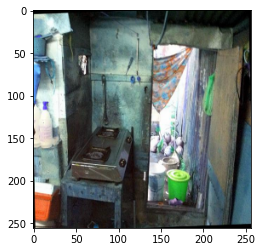

In [ ]:
testings(1)

In [ ]:
with open('/content/drive/MyDrive/CV/train_images.npy', 'wb') as f:
    np.save(f, x_train)

with open('/content/drive/MyDrive/CV/train_labels.npy', 'wb') as f:
    np.save(f, y_train)

In [ ]:
with open('/content/drive/MyDrive/CV/test_images.npy', 'wb') as f:
    np.save(f, x_test)

with open('/content/drive/MyDrive/CV/test_labels.npy', 'wb') as f:
    np.save(f, y_test)

In [ ]:
label_name

array(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
       'train', 'truck', 'boat', 'traffic light', 'bench', 'bird', 'cat',
       'dog', 'horse', 'giraffe', 'backpack', 'umbrella', 'handbag',
       'tie', 'skis', 'sports ball', 'baseball bat', 'baseball glove',
       'skateboard', 'surfboard', 'tennis racket', 'bottle', 'cup',
       'fork', 'knife', 'spoon', 'bowl', 'pizza', 'cake', 'chair',
       'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
       'laptop', 'remote', 'keyboard', 'cell phone', 'oven', 'sink',
       'book', 'clock', 'vase'], dtype='<U14')

In [ ]:
np.savetxt("/content/drive/MyDrive/CV/label_names.csv",label_name,delimiter=",",fmt='%s')

In [ ]:
x_train = np.load('/content/drive/MyDrive/CV/train_images.npy')
y_train = np.load('/content/drive/MyDrive/CV/train_labels.npy', allow_pickle=True)
x_test = np.load('/content/drive/MyDrive/CV/test_images.npy')
y_test = np.load('/content/drive/MyDrive/CV/test_labels.npy', allow_pickle=True)

In [ ]:
testings(0)

In [ ]:
testings_2(0)